In [1]:
import os
import sys

import math
import numpy
import networkx

import matplotlib.pyplot

sys.path.append(os.path.join(os.path.abspath(''), '..'))
import data_parser

In [2]:
INTERACTOME_FILE = "../Interactome/interactome_human.sif"

In [3]:
'''Set path for output figures'''
FIGURES_DIR = "./figures/"

In [4]:
def parse_RWR_ranks(ranks_file):
    '''
    Loads the ranks generated with MultiXrank
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    '''
    ENSG2rank = {}
 
    with open(ranks_file, 'r') as f:
        data = f.read().splitlines()
        for line in data:
            split_line = line.rstrip().split('\t')
            ENSG, rank = split_line

            ENSG2rank[ENSG] = int(rank)

    return ENSG2rank

In [5]:
def parse_GBA_ranks(ranks_file):
    '''
    Loads the scores generated with GBA_centrality_PR.py
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    - gene2ENSG: dict with key=gene, value=ENSG
    - ENSG2gene: dict key=ENSG, value=gene
    '''
    ENSG2rank = {}
    gene2ENSG = {}
    ENSG2gene = {}
 
    with open(ranks_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            split_line = line.rstrip().split('\t')
            ENSG, gene, rank = split_line

            ENSG2rank[ENSG] = int(rank)
            gene2ENSG[gene] = ENSG
            ENSG2gene[ENSG] = gene

    return ENSG2rank, gene2ENSG, ENSG2gene

In [6]:
def generate_random_ranks(interactome, ENSG2rank):
    # New code should use the integers method of a Generator instance instead of numpy.random.randint
    # https://numpy.org/doc/2.1/reference/random/generated/numpy.random.randint.html
    rng = numpy.random.default_rng()

    # 1D numpy array for left-out known causal gene ranks
    # size=len(left-out genes)
    ranks_random = numpy.zeros(len(ENSG2rank), dtype=numpy.uint64)

    n = 10000
    for i in range(n):
        # 1D numpy array for left-out gene ranks
        # size=len(left-out genes)
        tmp = rng.integers(low=1, high=len(interactome), size=ranks_random.shape, dtype=numpy.uint64)
        tmp = numpy.sort(tmp)
        ranks_random += tmp

    for j in range(len(ranks_random)):
        avg_rank = ranks_random[j] / n
        ranks_random[j] = avg_rank

    return ranks_random

In [7]:
def calculate_PageRank_ranks(causal_genes, interactome, alpha):
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

    # causal_genes: dict of causal genes with key=ENSG, value=1
    causal_genes = causal_genes.copy()
    for left_out in causal_genes:
        causal_genes[left_out] = 1

    ENSG2rank_pagerank = {}
    for left_out in list(causal_genes.keys()):
        del causal_genes[left_out]
        res_pagerank = networkx.pagerank(interactome, personalization=causal_genes, alpha=alpha)
        
        # save the left-out rank
        results_sorted = sorted(res_pagerank.keys(), key=lambda item: res_pagerank[item], reverse=True)
        rank_left_out = results_sorted.index(left_out) + 1  # + 1 because ranks start at 1 not 0

        ENSG2rank_pagerank[left_out] = rank_left_out

        # add left-out back to causal_genes
        causal_genes[left_out] = 1

    return ENSG2rank_pagerank

In [8]:
'''Parse interactome'''
interactome = data_parser.parse_interactome(interactome_file=INTERACTOME_FILE)
print(f"Interactome: {len(interactome.nodes())} proteins, {len(interactome.edges())} interactions")

Interactome: 16528 proteins, 243444 interactions


### Parameter: alpha

In [24]:
'''Set parameters with which the methods were run'''
PHENOTYPE = "MMAF" # to choose from: MMAF, NOA, DILCARD, HYPCARD, BC (breast cancer), CC (colon cancer), OG, PCD, POF
ALPHAS = [0.3, 0.5, 0.7]
D_MAX = 10

/tmp/ipykernel_14244/2125332111.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend(loc="lower right")


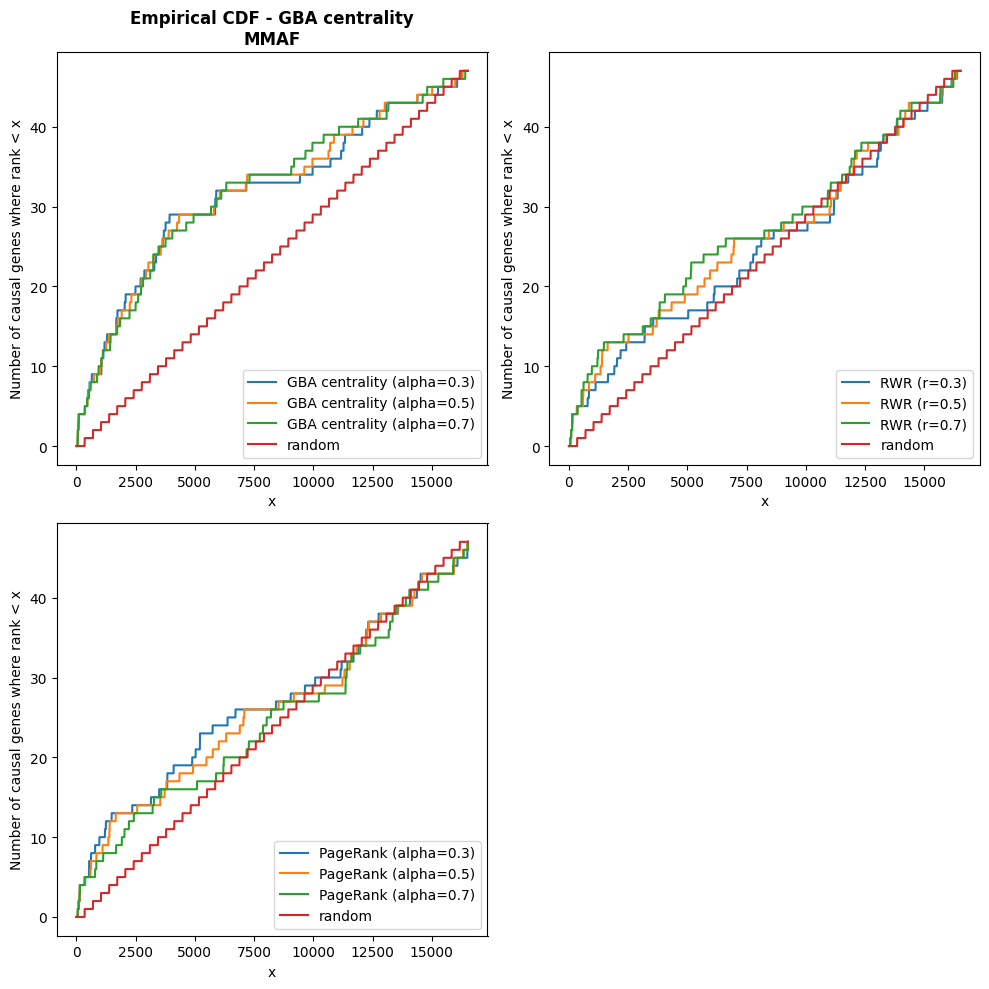

In [25]:
columns = 2
rows = math.ceil(3 / columns)  # number of methods = 3

fig, ax = matplotlib.pyplot.subplots(rows, columns, figsize=(columns * 5, rows * 5))
ax = ax.flatten()

for param in ALPHAS:
    ALPHA = param
    alpha = str(ALPHA).replace('.', '')

    ENSG2rank_RWR = parse_RWR_ranks(f"/home/kubicaj/workspace/MultiXrank/r{alpha}/{PHENOTYPE}/RWR_ranks_leave_one_out.tsv")
    ENSG2rank_GBA, _, _ = parse_GBA_ranks(f"../output/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/ranks_leave_one_out.tsv")
    ENSG2rank_pagerank = calculate_PageRank_ranks(causal_genes=ENSG2rank_GBA, interactome=interactome, alpha=ALPHA)

    ranks_RWR = []
    ranks_GBA = []
    ranks_pagerank = []

    for gene in ENSG2rank_RWR:
        ranks_RWR.append(ENSG2rank_RWR[gene])
        ranks_GBA.append(ENSG2rank_GBA[gene])
        ranks_pagerank.append(ENSG2rank_pagerank[gene])

    curve_RWR = []
    curve_GBA = []
    curve_pagerank = []
    
    for i in range(len(interactome)):
        curve_RWR.append(sum(rank <= i for rank in ranks_RWR))
        curve_GBA.append(sum(rank <= i for rank in ranks_GBA))
        curve_pagerank.append(sum(rank <= i for rank in ranks_pagerank))

    ax[0].plot(range(len(interactome)), curve_GBA, label=f"GBA centrality (alpha={ALPHA})")
    ax[1].plot(range(len(interactome)), curve_RWR, label=f"RWR (r={ALPHA})")
    ax[2].plot(range(len(interactome)), curve_pagerank, label=f"PageRank (alpha={ALPHA})")

    # Title based on phenotype
    title_map = {
        "MMAF": PHENOTYPE,
        "NOA": PHENOTYPE,
        "OG": PHENOTYPE,
        "PCD": PHENOTYPE,
        "POF": PHENOTYPE,
        "BC": "breast cancer",
        "CC": "colon cancer",
        "HYPCARD": "hypertrophic cardiomyopathy",
        "DILCARD": "dilated cardiomyopathy"
    }
    ax[0].set_title(f"Empirical CDF - GBA centrality\n{title_map.get(PHENOTYPE, PHENOTYPE)}", fontsize=12, weight='bold')

# calculate random ranks
ranks_random = generate_random_ranks(interactome, ENSG2rank_GBA)
curve_random = []
for i in range(len(interactome)):
    curve_random.append(sum(rank <= i for rank in ranks_random))

ax[0].plot(range(len(interactome)), curve_random, label="random")
ax[1].plot(range(len(interactome)), curve_random, label="random")
ax[2].plot(range(len(interactome)), curve_random, label="random")

for a in ax:
    a.set_xlabel("x")
    a.set_ylabel("Number of causal genes where rank < x")
    a.legend(loc="lower right")

# hide unused subplots (if number of images < grid size)
for i in range(len(ALPHAS), len(ax)):
    fig.delaxes(ax[i])

matplotlib.pyplot.tight_layout()
# matplotlib.pyplot.savefig(FIGURES_DIR + f"GBA_vs_RWR_vs_PageRank_alpha_parameter_CDF_{PHENOTYPE}", dpi=1000)

### Parameter: d_max

In [22]:
'''Set parameters with which the methods were run'''
PHENOTYPE = "CC" # to choose from: MMAF, NOA, DILCARD, HYPCARD, BC (breast cancer), CC (colon cancer), OG, PCD, POF
ALPHA = 0.5
D_MAX = [5, 10, 15]

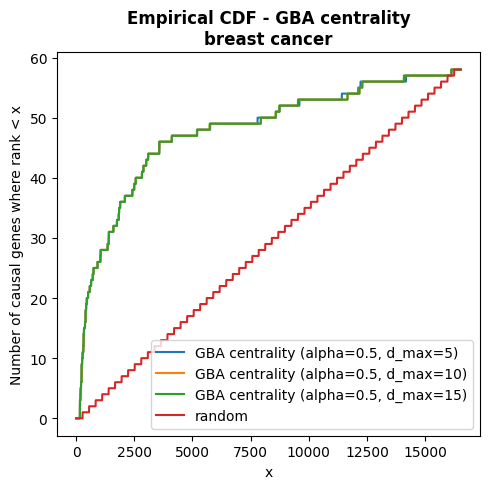

In [21]:
import math
import matplotlib.pyplot as plt

columns = 1
rows = math.ceil(1 / columns)  # assuming 1 method or phenotype

fig, ax = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))
if not isinstance(ax, (list, numpy.ndarray)):
    ax = [ax]

for param in D_MAX:
    alpha = str(ALPHA).replace('.', '')

    ENSG2rank_GBA, _, _ = parse_GBA_ranks(f"../output/{PHENOTYPE}/alpha{alpha}_d{param}/ranks_leave_one_out.tsv")

    ranks_GBA = [ENSG2rank_GBA[gene] for gene in ENSG2rank_GBA]

    curve_GBA = []
    for i in range(len(interactome)):
        curve_GBA.append(sum(rank <= i for rank in ranks_GBA))

    ax[0].plot(range(len(interactome)), curve_GBA, label=f"GBA centrality (alpha={ALPHA}, d_max={param})")

    # Title based on phenotype
    title_map = {
        "MMAF": PHENOTYPE,
        "NOA": PHENOTYPE,
        "OG": PHENOTYPE,
        "PCD": PHENOTYPE,
        "POF": PHENOTYPE,
        "BC": "breast cancer",
        "CC": "colon cancer",
        "HYPCARD": "hypertrophic cardiomyopathy",
        "DILCARD": "dilated cardiomyopathy"
    }
    ax[0].set_title(f"Empirical CDF - GBA centrality\n{title_map.get(PHENOTYPE, PHENOTYPE)}", fontsize=12, weight='bold')

# Random baseline
ranks_random = generate_random_ranks(interactome, ENSG2rank_GBA)
curve_random = [sum(rank <= i for rank in ranks_random) for i in range(len(interactome))]
ax[0].plot(range(len(interactome)), curve_random, label="random")

for a in ax:
    a.set_xlabel("x")
    a.set_ylabel("Number of causal genes where rank < x")
    a.legend(loc="lower right")

plt.tight_layout()
plt.savefig(FIGURES_DIR + f"GBA_vs_RWR_vs_PageRank_dmax_parameter_CDF_{PHENOTYPE}", dpi=1000)